In [1]:
import pickle
import numpy as np
from tensorflow import keras
import pandas as pd
import os, datetime
from utils import data_read_dict, data_read_concat, data_merge
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
print('Tensorflow version: {}'.format(tf.__version__))

import matplotlib.pyplot as plt
plt.style.use('seaborn')

import warnings
warnings.filterwarnings('ignore')

Tensorflow version: 2.6.0-dev20210517


In [2]:
import platform
if platform.node() == "msbq":
    from tensorflow.python.client import device_lib
    print(device_lib.list_local_devices())
    print(tf.__version__)
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    tf.config.list_physical_devices('GPU')
    !python --version

#     tf.config.list_physical_devices('GPU')
#     gpus = tf.config.experimental.list_physical_devices('GPU')
#     if gpus:
#       # Restrict TensorFlow to only allocate 4GB of memory on the first GPU
#       try:
#         tf.config.experimental.set_virtual_device_configuration(
#             gpus[0],
#             [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#       except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)
#         print('asdf')


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12444499183371284730
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6062604288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16044972329684874393
physical_device_desc: "device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:2d:00.0, compute capability: 7.5"
]
2.6.0-dev20210517
Num GPUs Available:  1
Python 3.8.10


## Hyperparameters

In [3]:
batch_size = 32
seq_len = 128

d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256


## Load data

In [4]:
IBM_path = '../data/10min Dataset.csv'

# df = pd.read_csv(IBM_path, delimiter=';', usecols=['Dates', 'EURUSD BGNE Curncy Bid Open', 'EURUSD BGNE Curncy Bid Close', 'EURUSD BGNE Curncy Bid High', 'EURUSD BGNE Curncy Bid Low', 'EURUSD BGNE Curncy Bid Number Ticks', 'EURUSD BGNE Curncy Ask Open', 'EURUSD BGNE Curncy Ask Close', 'EURUSD BGNE Curncy Ask High', 'EURUSD BGNE Curncy Ask Low', 'EURUSD BGNE Curncy Ask Number Ticks', 'USDJPY BGNE Curncy Bid Open', 'USDJPY BGNE Curncy Bid Close', 'USDJPY BGNE Curncy Bid High', 'USDJPY BGNE Curncy Bid Low', 'USDJPY BGNE Curncy Bid Number Ticks', 'USDJPY BGNE Curncy Ask Open', 'USDJPY BGNE Curncy Ask Close', 'USDJPY BGNE Curncy Ask High', 'USDJPY BGNE Curncy Ask Low', 'USDJPY BGNE Curncy Ask Number Ticks', 'GBPUSD BGNE Curncy Bid Open', 'GBPUSD BGNE Curncy Bid Close', 'GBPUSD BGNE Curncy Bid High', 'GBPUSD BGNE Curncy Bid Low', 'GBPUSD BGNE Curncy Bid Number Ticks', 'GBPUSD BGNE Curncy Ask Open', 'GBPUSD BGNE Curncy Ask Close', 'GBPUSD BGNE Curncy Ask High', 'GBPUSD BGNE Curncy Ask Low', 'GBPUSD BGNE Curncy Ask Number Ticks', 'AUDUSD BGNE Curncy Bid Open', 'AUDUSD BGNE Curncy Bid Close', 'AUDUSD BGNE Curncy Bid High', 'AUDUSD BGNE Curncy Bid Low', 'AUDUSD BGNE Curncy Bid Number Ticks', 'AUDUSD BGNE Curncy Ask Open', 'AUDUSD BGNE Curncy Ask Close', 'AUDUSD BGNE Curncy Ask High', 'AUDUSD BGNE Curncy Ask Low', 'AUDUSD BGNE Curncy Ask Number Ticks', 'USDCAD BGNE Curncy Bid Open', 'USDCAD BGNE Curncy Bid Close', 'USDCAD BGNE Curncy Bid High', 'USDCAD BGNE Curncy Bid Low', 'USDCAD BGNE Curncy Bid Number Ticks', 'USDCAD BGNE Curncy Ask Open', 'USDCAD BGNE Curncy Ask Close', 'USDCAD BGNE Curncy Ask High', 'USDCAD BGNE Curncy Ask Low', 'USDCAD BGNE Curncy Ask Number Ticks', 'USDCHF BGNE Curncy Bid Open', 'USDCHF BGNE Curncy Bid Close', 'USDCHF BGNE Curncy Bid High', 'USDCHF BGNE Curncy Bid Low', 'USDCHF BGNE Curncy Bid Number Ticks', 'USDCHF BGNE Curncy Ask Open', 'USDCHF BGNE Curncy Ask Close', 'USDCHF BGNE Curncy Ask High', 'USDCHF BGNE Curncy Ask Low', 'USDCHF BGNE Curncy Ask Number Ticks', 'NZDUSD BGNE Curncy Bid Open', 'NZDUSD BGNE Curncy Bid Close', 'NZDUSD BGNE Curncy Bid High', 'NZDUSD BGNE Curncy Bid Low', 'NZDUSD BGNE Curncy Bid Number Ticks', 'NZDUSD BGNE Curncy Ask Open', 'NZDUSD BGNE Curncy Ask Close', 'NZDUSD BGNE Curncy Ask High', 'NZDUSD BGNE Curncy Ask Low', 'NZDUSD BGNE Curncy Ask Number Ticks', 'EURJPY BGNE Curncy Bid Open', 'EURJPY BGNE Curncy Bid Close', 'EURJPY BGNE Curncy Bid High', 'EURJPY BGNE Curncy Bid Low', 'EURJPY BGNE Curncy Bid Number Ticks', 'EURJPY BGNE Curncy Ask Open', 'EURJPY BGNE Curncy Ask Close', 'EURJPY BGNE Curncy Ask High', 'EURJPY BGNE Curncy Ask Low', 'EURJPY BGNE Curncy Ask Number Ticks', 'GBPJPY BGNE Curncy Bid Open', 'GBPJPY BGNE Curncy Bid Close', 'GBPJPY BGNE Curncy Bid High', 'GBPJPY BGNE Curncy Bid Low', 'GBPJPY BGNE Curncy Bid Number Ticks', 'GBPJPY BGNE Curncy Ask Open', 'GBPJPY BGNE Curncy Ask Close', 'GBPJPY BGNE Curncy Ask High', 'GBPJPY BGNE Curncy Ask Low', 'GBPJPY BGNE Curncy Ask Number Ticks', 'EURGBP BGNE Curncy Bid Open', 'EURGBP BGNE Curncy Bid Close', 'EURGBP BGNE Curncy Bid High', 'EURGBP BGNE Curncy Bid Low', 'EURGBP BGNE Curncy Bid Number Ticks', 'EURGBP BGNE Curncy Ask Open', 'EURGBP BGNE Curncy Ask Close', 'EURGBP BGNE Curncy Ask High', 'EURGBP BGNE Curncy Ask Low', 'EURGBP BGNE Curncy Ask Number Ticks', 'AUDJPY BGNE Curncy Bid Open', 'AUDJPY BGNE Curncy Bid Close', 'AUDJPY BGNE Curncy Bid High', 'AUDJPY BGNE Curncy Bid Low', 'AUDJPY BGNE Curncy Bid Number Ticks', 'AUDJPY BGNE Curncy Ask Open', 'AUDJPY BGNE Curncy Ask Close', 'AUDJPY BGNE Curncy Ask High', 'AUDJPY BGNE Curncy Ask Low', 'AUDJPY BGNE Curncy Ask Number Ticks', 'EURAUD BGNE Curncy Bid Open', 'EURAUD BGNE Curncy Bid Close', 'EURAUD BGNE Curncy Bid High', 'EURAUD BGNE Curncy Bid Low', 'EURAUD BGNE Curncy Bid Number Ticks', 'EURAUD BGNE Curncy Ask Open', 'EURAUD BGNE Curncy Ask Close', 'EURAUD BGNE Curncy Ask High', 'EURAUD BGNE Curncy Ask Low', 'EURAUD BGNE Curncy Ask Number Ticks', 'EURCHF BGNE Curncy Bid Open', 'EURCHF BGNE Curncy Bid Close', 'EURCHF BGNE Curncy Bid High', 'EURCHF BGNE Curncy Bid Low', 'EURCHF BGNE Curncy Bid Number Ticks', 'EURCHF BGNE Curncy Ask Open', 'EURCHF BGNE Curncy Ask Close', 'EURCHF BGNE Curncy Ask High', 'EURCHF BGNE Curncy Ask Low', 'EURCHF BGNE Curncy Ask Number Ticks', 'AUDNZD BGNE Curncy Bid Open', 'AUDNZD BGNE Curncy Bid Close', 'AUDNZD BGNE Curncy Bid High', 'AUDNZD BGNE Curncy Bid Low', 'AUDNZD BGNE Curncy Bid Number Ticks', 'AUDNZD BGNE Curncy Ask Open', 'AUDNZD BGNE Curncy Ask Close', 'AUDNZD BGNE Curncy Ask High', 'AUDNZD BGNE Curncy Ask Low', 'AUDNZD BGNE Curncy Ask Number Ticks', 'NZDJPY BGNE Curncy Bid Open', 'NZDJPY BGNE Curncy Bid Close', 'NZDJPY BGNE Curncy Bid High', 'NZDJPY BGNE Curncy Bid Low', 'NZDJPY BGNE Curncy Bid Number Ticks', 'NZDJPY BGNE Curncy Ask Open', 'NZDJPY BGNE Curncy Ask Close', 'NZDJPY BGNE Curncy Ask High', 'NZDJPY BGNE Curncy Ask Low', 'NZDJPY BGNE Curncy Ask Number Ticks', 'GBPAUD BGNE Curncy Bid Open', 'GBPAUD BGNE Curncy Bid Close', 'GBPAUD BGNE Curncy Bid High', 'GBPAUD BGNE Curncy Bid Low', 'GBPAUD BGNE Curncy Bid Number Ticks', 'GBPAUD BGNE Curncy Ask Open', 'GBPAUD BGNE Curncy Ask Close', 'GBPAUD BGNE Curncy Ask High', 'GBPAUD BGNE Curncy Ask Low', 'GBPAUD BGNE Curncy Ask Number Ticks', 'GBPCAD BGNE Curncy Bid Open', 'GBPCAD BGNE Curncy Bid Close', 'GBPCAD BGNE Curncy Bid High', 'GBPCAD BGNE Curncy Bid Low', 'GBPCAD BGNE Curncy Bid Number Ticks', 'GBPCAD BGNE Curncy Ask Open', 'GBPCAD BGNE Curncy Ask Close', 'GBPCAD BGNE Curncy Ask High', 'GBPCAD BGNE Curncy Ask Low', 'GBPCAD BGNE Curncy Ask Number Ticks', 'EURNZD BGNE Curncy Bid Open', 'EURNZD BGNE Curncy Bid Close', 'EURNZD BGNE Curncy Bid High', 'EURNZD BGNE Curncy Bid Low', 'EURNZD BGNE Curncy Bid Number Ticks', 'EURNZD BGNE Curncy Ask Open', 'EURNZD BGNE Curncy Ask Close', 'EURNZD BGNE Curncy Ask High', 'EURNZD BGNE Curncy Ask Low', 'EURNZD BGNE Curncy Ask Number Ticks', 'AUDCAD BGNE Curncy Bid Open', 'AUDCAD BGNE Curncy Bid Close', 'AUDCAD BGNE Curncy Bid High', 'AUDCAD BGNE Curncy Bid Low', 'AUDCAD BGNE Curncy Bid Number Ticks', 'AUDCAD BGNE Curncy Ask Open', 'AUDCAD BGNE Curncy Ask Close', 'AUDCAD BGNE Curncy Ask High', 'AUDCAD BGNE Curncy Ask Low', 'AUDCAD BGNE Curncy Ask Number Ticks', 'GBPCHF BGNE Curncy Bid Open', 'GBPCHF BGNE Curncy Bid Close', 'GBPCHF BGNE Curncy Bid High', 'GBPCHF BGNE Curncy Bid Low', 'GBPCHF BGNE Curncy Bid Number Ticks', 'GBPCHF BGNE Curncy Ask Open', 'GBPCHF BGNE Curncy Ask Close', 'GBPCHF BGNE Curncy Ask High', 'GBPCHF BGNE Curncy Ask Low', 'GBPCHF BGNE Curncy Ask Number Ticks', 'EURUSDV1M Curncy 44278 Open', 'USDJPYV1M Curncy  Open', 'GBPUSDV1M Curncy  Open', 'AUDUSDV1M Curncy  Open', 'USDCADV1M Curncy  Open', 'USDCHFV1M Curncy  Open', 'NZDUSDV1M Curncy  Open', 'EURJPYV1M Curncy  Open', 'GBPJPYV1M Curncy  Open', 'EURGBPV1M Curncy  Open', 'AUDJPYV1M Curncy  Open', 'EURAUDV1M Curncy  Open', 'EURCHFV1M Curncy  Open', 'AUDNZDV1M Curncy  Open', 'NZDJPYV1M Curncy  Open', 'GBPAUDV1M Curncy  Open', 'GBPCADV1M Curncy  Open', 'EURNZDV1M Curncy  Open', 'AUDCADV1M Curncy  Open', 'GBPCHFV1M Curncy  Open', 'EURUSDV3M Curncy Trade Open', 'USDJPYV3M Curncy Trade Open', 'GBPUSDV3M Curncy Trade Open', 'AUDUSDV3M Curncy Trade Open', 'USDCADV3M Curncy Trade Open', 'USDCHFV3M Curncy Trade Open', 'NZDUSDV3M Curncy Trade Open', 'EURJPYV3M Curncy Trade Open', 'GBPJPYV3M Curncy Trade Open', 'EURGBPV3M Curncy Trade Open', 'AUDJPYV3M Curncy Trade Open', 'EURAUDV3M Curncy Trade Open', 'EURCHFV3M Curncy Trade Open', 'AUDNZDV3M Curncy Trade Open', 'NZDJPYV3M Curncy Trade Open', 'GBPAUDV3M Curncy Trade Open', 'GBPCADV3M Curncy Trade Open', 'EURNZDV3M Curncy Trade Open', 'AUDCADV3M Curncy Trade Open', 'GBPCHFV3M Curncy Trade Open', 'EURUSDV1Y Curncy Trade Open', 'USDJPYV1Y Curncy Trade Open', 'GBPUSDV1Y Curncy Trade Open', 'AUDUSDV1Y Curncy Trade Open', 'USDCADV1Y Curncy Trade Open', 'USDCHFV1Y Curncy Trade Open', 'NZDUSDV1Y Curncy Trade Open', 'EURJPYV1Y Curncy Trade Open', 'GBPJPYV1Y Curncy Trade Open', 'EURGBPV1Y Curncy Trade Open', 'AUDJPYV1Y Curncy Trade Open', 'EURAUDV1Y Curncy Trade Open', 'EURCHFV1Y Curncy Trade Open', 'AUDNZDV1Y Curncy Trade Open', 'NZDJPYV1Y Curncy Trade Open', 'GBPAUDV1Y Curncy Trade Open', 'GBPCADV1Y Curncy Trade Open', 'EURNZDV1Y Curncy Trade Open', 'AUDCADV1Y Curncy Trade Open', 'GBPCHFV1Y Curncy Trade Open', 'EURUSD25R1M Curncy Trade Open', 'USDJPY25R1M Curncy Trade Open', 'GBPUSD25R1M Curncy Trade Open', 'AUDUSD25R1M Curncy Trade Open', 'USDCAD25R1M Curncy Trade Open', 'USDCHF25R1M Curncy Trade Open', 'NZDUSD25R1M Curncy Trade Open', 'EURJPY25R1M Curncy Trade Open', 'GBPJPY25R1M Curncy Trade Open', 'EURGBP25R1M Curncy Trade Open', 'AUDJPY25R1M Curncy Trade Open', 'EURAUD25R1M Curncy Trade Open', 'EURCHF25R1M Curncy Trade Open', 'AUDNZD25R1M Curncy Trade Open', 'NZDJPY25R1M Curncy Trade Open', 'GBPAUD25R1M Curncy Trade Open', 'GBPCAD25R1M Curncy Trade Open', 'EURNZD25R1M Curncy Trade Open', 'AUDCAD25R1M Curncy Trade Open', 'GBPCHF25R1M Curncy Trade Open', 'EURUSD25R3M Curncy 44278 Open', 'USDJPY25R3M Curncy  Open', 'GBPUSD25R3M Curncy  Open', 'AUDUSD25R3M Curncy  Open', 'USDCAD25R3M Curncy  Open', 'USDCHF25R3M Curncy  Open', 'NZDUSD25R3M Curncy  Open', 'EURJPY25R3M Curncy  Open', 'GBPJPY25R3M Curncy  Open', 'EURGBP25R3M Curncy  Open', 'AUDJPY25R3M Curncy  Open', 'EURAUD25R3M Curncy  Open', 'EURCHF25R3M Curncy  Open', 'AUDNZD25R3M Curncy  Open', 'NZDJPY25R3M Curncy  Open', 'GBPAUD25R3M Curncy  Open', 'GBPCAD25R3M Curncy  Open', 'EURNZD25R3M Curncy  Open', 'AUDCAD25R3M Curncy  Open', 'GBPCHF25R3M Curncy  Open', 'EURUSDCR Curncy Trade Open', 'USDJPYCR Curncy Trade Open', 'GBPUSDCR Curncy Trade Open', 'AUDUSDCR Curncy Trade Open', 'USDCADCR Curncy Trade Open', 'USDCHFCR Curncy Trade Open', 'NZDUSDCR Curncy Trade Open', 'EURJPYCR Curncy Trade Open', 'GBPJPYCR Curncy Trade Open', 'EURGBPCR Curncy Trade Open', 'AUDJPYCR Curncy Trade Open', 'EURAUDCR Curncy Trade Open', 'EURCHFCR Curncy Trade Open', 'AUDNZDCR Curncy Trade Open', 'NZDJPYCR Curncy Trade Open', 'GBPAUDCR Curncy Trade Open', 'GBPCADCR Curncy Trade Open', 'EURNZDCR Curncy Trade Open', 'AUDCADCR Curncy Trade Open', 'GBPCHFCR Curncy Trade Open', 'EURUSD1M Curncy Trade Open', 'USDJPY1M Curncy Trade Open', 'GBPUSD1M Curncy Trade Open', 'AUDUSD1M Curncy Trade Open', 'USDCAD1M Curncy Trade Open', 'USDCHF1M Curncy Trade Open', 'NZDUSD1M Curncy Trade Open', 'EURJPY1M Curncy Trade Open', 'GBPJPY1M Curncy Trade Open', 'EURGBP1M Curncy Trade Open', 'AUDJPY1M Curncy Trade Open', 'EURAUD1M Curncy Trade Open', 'EURCHF1M Curncy Trade Open', 'AUDNZD1M Curncy Trade Open', 'NZDJPY1M Curncy Trade Open', 'GBPAUD1M Curncy Trade Open', 'GBPCAD1M Curncy Trade Open', 'EURNZD1M Curncy Trade Open', 'AUDCAD1M Curncy Trade Open', 'GBPCHF1M Curncy Trade Open', 'EURUSD3M Curncy Trade Open', 'USDJPY3M Curncy Trade Open', 'GBPUSD3M Curncy Trade Open', 'AUDUSD3M Curncy Trade Open', 'USDCAD3M Curncy Trade Open', 'USDCHF3M Curncy Trade Open', 'NZDUSD3M Curncy Trade Open', 'EURJPY3M Curncy Trade Open', 'GBPJPY3M Curncy Trade Open', 'EURGBP3M Curncy Trade Open', 'AUDJPY3M Curncy Trade Open', 'EURAUD3M Curncy Trade Open', 'EURCHF3M Curncy Trade Open', 'AUDNZD3M Curncy Trade Open', 'NZDJPY3M Curncy Trade Open', 'GBPAUD3M Curncy Trade Open', 'GBPCAD3M Curncy Trade Open', 'EURNZD3M Curncy Trade Open', 'AUDCAD3M Curncy Trade Open', 'GBPCHF3M Curncy Trade Open', 'CL1 Comdty Trade Open', 'CO1 Comdty Trade Open', 'HG1 Comdty Trade Open', 'UXA1 Comdty Trade Open', 'NG1 Comdty Trade Open', 'GC1 Comdty Trade Open', 'LB1 Comdty Trade Open', 'C 1 Comdty Trade Open', 'S 1 Comdty Trade Open', 'HRC1 Comdty Trade Open', 'XB1 Comdty Trade Open', 'MO1 Comdty Trade Open', 'IOE1 Comdty Trade Open', 'SCO1 Comdty Trade Open', 'SB1 Comdty Trade Open', 'W 1 Comdty Trade Open', 'HO1 Comdty Trade Open', 'KO1 Comdty Trade Open', 'BO1 Comdty Trade Open', 'SI1 Comdty Trade Open', 'USSW10 BGN Curncy Trade Open', 'EUSA10 BGN Curncy Trade Open', 'USSW5 BGN Curncy Trade Open', 'USSW30 BGN Curncy Trade Open', 'USSP10 BGN Curncy Trade Open', 'USSWAP10 BGN Curncy Trade Open', 'EUSA5 BGN Curncy Trade Open', 'EUSA30 BGN Curncy Trade Open', 'USSP30 BGN Curncy Trade Open', 'USSW2 BGN Curncy Trade Open', 'USSWAP5 BGN Curncy Trade Open', 'EUSA20 BGN Curncy Trade Open', 'USSP5 BGN Curncy Trade Open', 'USSW3 BGN Curncy Trade Open', 'USSWIT10 BGN Curncy Trade Open', 'JYBSC BGN Curncy Trade Open', 'JYSW10 BGN Curncy Trade Open', 'ADSWAP10 BGN Curncy Trade Open', 'PZSW5 BGN Curncy Trade Open', 'ES1 Index Trade Open', 'NQ1 Index Trade Open', 'VG1 Index Trade Open', 'GX1 Index Trade Open', 'UX1 Index Trade Open', 'NK1 Index Trade Open', 'RTY1 Index Trade Open', 'XU1 Index Trade Open', 'MES1 Index Trade Open', 'DM1 Index Trade Open', 'TP1 Index Trade Open', 'NH1 Index Trade Open', 'IH1 Index Trade Open', 'XP1 Index Trade Open', 'SP1 Index Trade Open', 'Z 1 Index Trade Open', 'TY1 Comdty Trade Open', 'RX1 Comdty Trade Open', 'JB1 Comdty Trade Open', 'US1 Comdty Trade Open', 'IK1 Comdty Trade Open', 'ED1 Comdty Trade Open', 'WN1 Comdty Trade Open', 'YM1 Comdty Trade Open', 'FV1 Comdty Trade Open', 'G 1 Comdty Trade Open', 'UB1 Comdty Trade Open', 'FF1 Comdty Trade Open', 'OE1 Comdty Trade Open', 'TU1 Comdty Trade Open', 'KE1 Comdty Trade Open', 'DU1 Comdty Trade Open', 'UXY1 Comdty Trade Open', 'CN1 Comdty Trade Open', 'KAA1 Comdty Trade Open'])
df = pd.read_csv(IBM_path, delimiter=';')

# Replace 0 to avoid dividing by 0 later on
df.replace(to_replace=0, method='ffill', inplace=True) 
df.drop('UXA1 Comdty Trade Open', axis=1, inplace=True)
df['Dates'] = pd.to_datetime(df['Dates'], format='%d.%m.%y %H:%M')
df.sort_values('Dates', inplace=True)
df.sort_values('Dates')
df.index = df['Dates']
df.tail()

,Dates,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,...,G 1 Comdty Trade Open,UB1 Comdty Trade Open,FF1 Comdty Trade Open,OE1 Comdty Trade Open,TU1 Comdty Trade Open,KE1 Comdty Trade Open,DU1 Comdty Trade Open,UXY1 Comdty Trade Open,CN1 Comdty Trade Open,KAA1 Comdty Trade Open
Dates,,,,,,,,,,,,,,,,,,,,,
2021-03-22 23:10:00,2021-03-22 23:10:00,1.19315,1.19339,1.19348,1.19313,952,1.19326,1.19348,1.19355,1.19320,...,128.55,205.64,99.93,135.19,110.4375,110.81,112.125,144.468750,140.89,126.25
2021-03-22 23:20:00,2021-03-22 23:20:00,1.19338,1.19327,1.19343,1.19326,958,1.19349,1.19337,1.19351,1.19332,...,128.55,205.64,99.93,135.19,110.4375,110.81,112.125,144.531250,140.89,126.25
2021-03-22 23:30:00,2021-03-22 23:30:00,1.19327,1.19330,1.19344,1.19320,1002,1.19336,1.19333,1.19350,1.19325,...,128.55,205.64,99.93,135.19,110.4375,110.81,112.125,144.531250,140.89,126.25
2021-03-22 23:40:00,2021-03-22 23:40:00,1.19327,1.19335,1.19345,1.19324,1039,1.19334,1.19341,1.19351,1.19330,...,128.55,205.64,99.93,135.19,110.4375,110.81,112.125,144.562500,140.89,126.25
2021-03-22 23:50:00,2021-03-22 23:50:00,1.19335,1.19335,1.19341,1.19330,1083,1.19343,1.19340,1.19348,1.19336,...,128.55,205.64,99.93,135.19,110.4375,110.81,112.125,144.640625,140.89,126.25


In [5]:
df_metrics = data_merge(data_read_dict('../data/bbg/'))
df_metrics = df_metrics.iloc[::-1, :].bfill().iloc[::-1, :]
df_metrics.shape

(15926, 840)

In [6]:
df_merged = pd.merge(df, df_metrics, left_index=True, right_index=True, how='outer')
df_merged = df_merged.loc[df_merged.index <= max(df.Dates),:]
d = pd.isna(df_metrics).any(axis=1)
df_merged = df_merged.loc[df_merged.index >= df_metrics.loc[~d].index.min()]
df_merged.loc[~pd.isna(df_merged).any(axis=1)]

,Dates,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,...,usdjpy___TAS_K,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR
Dates,,,,,,,,,,,,,,,,,,,,,
2020-11-02 08:20:00,2020-11-02 08:20:00,1.16400,1.16389,1.16422,1.16371,1576.0,1.16404,1.16393,1.16424,1.16374,...,100.000000,79.333333,71.502564,69.892308,104.710617,104.576931,104.754444,104.730164,104.762000,0.000000
2020-11-02 08:30:00,2020-11-02 08:30:00,1.16389,1.16320,1.16391,1.16302,1596.0,1.16393,1.16324,1.16395,1.16305,...,100.000000,86.000000,74.651282,71.776068,104.721683,104.576931,104.764444,104.733712,104.773333,0.000000
2020-11-02 08:40:00,2020-11-02 08:40:00,1.16320,1.16386,1.16389,1.16308,1647.0,1.16324,1.16388,1.16393,1.16312,...,92.307692,89.461538,78.876923,75.010256,104.732429,104.576931,104.777778,104.738813,104.788000,-7.692308
2020-11-02 08:50:00,2020-11-02 08:50:00,1.16380,1.16301,1.16398,1.16269,1595.0,1.16386,1.16304,1.16402,1.16273,...,94.117647,93.285068,83.944193,79.157466,104.742358,104.576931,104.795556,104.746303,104.812000,-5.882353
2020-11-02 09:00:00,2020-11-02 09:00:00,1.16298,1.16312,1.16322,1.16251,1632.0,1.16303,1.16313,1.16326,1.16256,...,100.000000,97.285068,89.073002,83.964706,104.763179,104.576931,104.816667,104.756070,104.832667,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-22 23:10:00,2021-03-22 23:10:00,1.19315,1.19339,1.19348,1.19313,952.0,1.19326,1.19348,1.19355,1.19320,...,42.857143,77.142857,89.367965,91.595516,108.802835,108.751982,108.835556,108.811932,108.828000,-80.000000
2021-03-22 23:20:00,2021-03-22 23:20:00,1.19338,1.19327,1.19343,1.19326,958.0,1.19349,1.19337,1.19351,1.19332,...,42.857143,65.714286,83.318903,88.484848,108.802835,108.751982,108.826667,108.811868,108.820000,-80.000000
2021-03-22 23:30:00,2021-03-22 23:30:00,1.19327,1.19330,1.19344,1.19320,1002.0,1.19336,1.19333,1.19350,1.19325,...,28.571429,54.285714,75.555556,82.747475,108.802835,108.860237,108.816667,108.811405,108.811333,-100.000000


In [7]:
df = df_merged[:]
df.shape

(20254, 1274)

## Plot 10min EURUSD closing prices and volatility

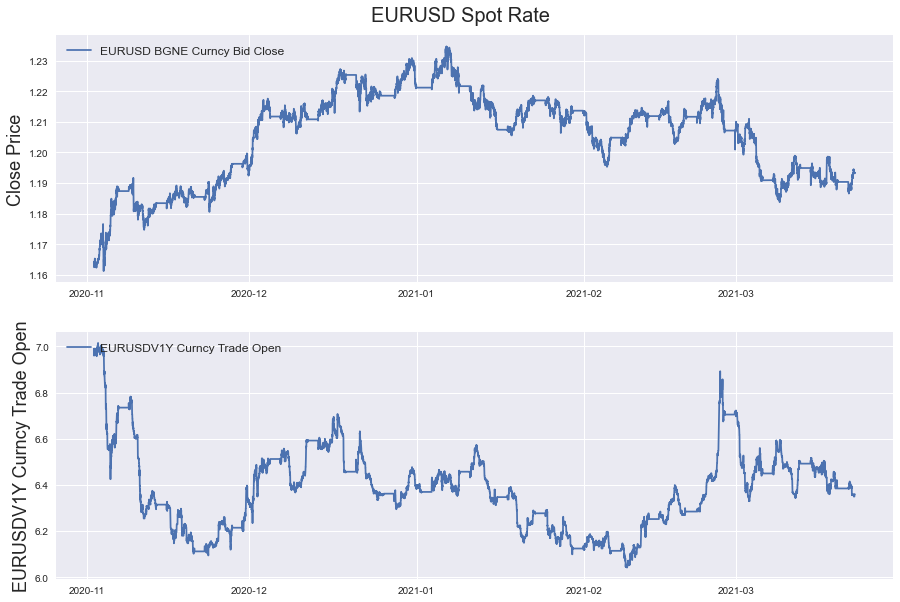

In [8]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("EURUSD Spot Rate", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
# ax1.plot(df['EURUSD BGNE Curncy Bid Close'], label='EURUSD BGNE Curncy Bid Close')
ax1.plot(df['Dates'], df['EURUSD BGNE Curncy Bid Close'], label='EURUSD BGNE Curncy Bid Close')
#ax1.set_xticks(range(0, df.shape[0], 1464))
#ax1.set_xticklabels(df['Dates'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
# ax2.plot(df['EURUSDV1Y Curncy Trade Open'], label='EURUSDV1Y Curncy Trade Open')
ax2.plot(df['Dates'], df['EURUSDV1Y Curncy Trade Open'], label='EURUSDV1Y Curncy Trade Open')
#ax2.set_xticks(range(0, df.shape[0], 1464))
#ax2.set_xticklabels(df['Dates'].loc[::1464])
ax2.set_ylabel('EURUSDV1Y Curncy Trade Open', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

## Calculate normalized percentage change of all columns

In [9]:
'''Calculate percentage change'''
df = df.set_index('Dates')
df.pct_change()

df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

In [10]:
'''Normalize price columns'''
df = (df - df.mean()) / (df.max() - df.min())
df.columns[np.isnan(df).any(axis=0)]

Index([], dtype='object')

In [11]:
#df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
#np.isinf(df)
#df

## Create training, validation and test split

In [12]:
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series

df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Convert pandas columns into arrays
train_data = df_train.values
train_data_dates = df_train.index.values  # !!!NEW
val_data = df_val.values
val_data_dates = df_val.index.values  # !!!NEW
test_data = df_test.values
test_data_dates = df_test.index.values  # !!!NEW
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

df_train.head()

Training data shape: (11761, 1273)
Validation data shape: (1470, 1273)
Test data shape: (1470, 1273)


,EURUSD BGNE Curncy Bid Open,EURUSD BGNE Curncy Bid Close,EURUSD BGNE Curncy Bid High,EURUSD BGNE Curncy Bid Low,EURUSD BGNE Curncy Bid Number Ticks,EURUSD BGNE Curncy Ask Open,EURUSD BGNE Curncy Ask Close,EURUSD BGNE Curncy Ask High,EURUSD BGNE Curncy Ask Low,EURUSD BGNE Curncy Ask Number Ticks,...,usdjpy___TAS_K,usdjpy___TAS_D,usdjpy___TAS_DS,usdjpy___TAS_DSS,usdjpy___TRENDER_UP,usdjpy___TRENDER_DN,usdjpy___TMAVG,usdjpy___VMAVG,usdjpy___WMAVG,usdjpy___WLPR
Dates,,,,,,,,,,,,,,,,,,,,,
2020-11-02 08:20:00,-0.559804,-0.561330,-0.568648,-0.554952,0.069035,-0.560642,-0.562526,-0.570526,-0.556325,0.069035,...,0.492777,0.286028,0.210139,0.195253,-0.035189,-0.050749,-0.026994,-0.030783,-0.025916,0.492415
2020-11-02 08:30:00,-0.561302,-0.570724,-0.572929,-0.564271,0.080522,-0.562140,-0.571930,-0.574533,-0.565645,0.080522,...,0.492777,0.352695,0.242083,0.214519,-0.033524,-0.050749,-0.025499,-0.030244,-0.024220,0.492415
2020-11-02 08:40:00,-0.570696,-0.561738,-0.573205,-0.563461,0.109816,-0.571537,-0.563208,-0.574810,-0.564700,0.109816,...,0.415854,0.387310,0.284951,0.247597,-0.031907,-0.050749,-0.023506,-0.029469,-0.022025,0.415492
2020-11-02 08:50:00,-0.562527,-0.573311,-0.571962,-0.568728,0.079948,-0.563093,-0.574655,-0.573566,-0.569968,0.079948,...,0.433953,0.425546,0.336358,0.290013,-0.030413,-0.050749,-0.020849,-0.028331,-0.018433,0.433592
2020-11-02 09:00:00,-0.573691,-0.571813,-0.582456,-0.571160,0.101200,-0.574397,-0.573429,-0.584068,-0.572264,0.101200,...,0.492777,0.465546,0.388390,0.339179,-0.027280,-0.050749,-0.017693,-0.026848,-0.015339,0.492415


## Plot daily changes of close prices and volatility

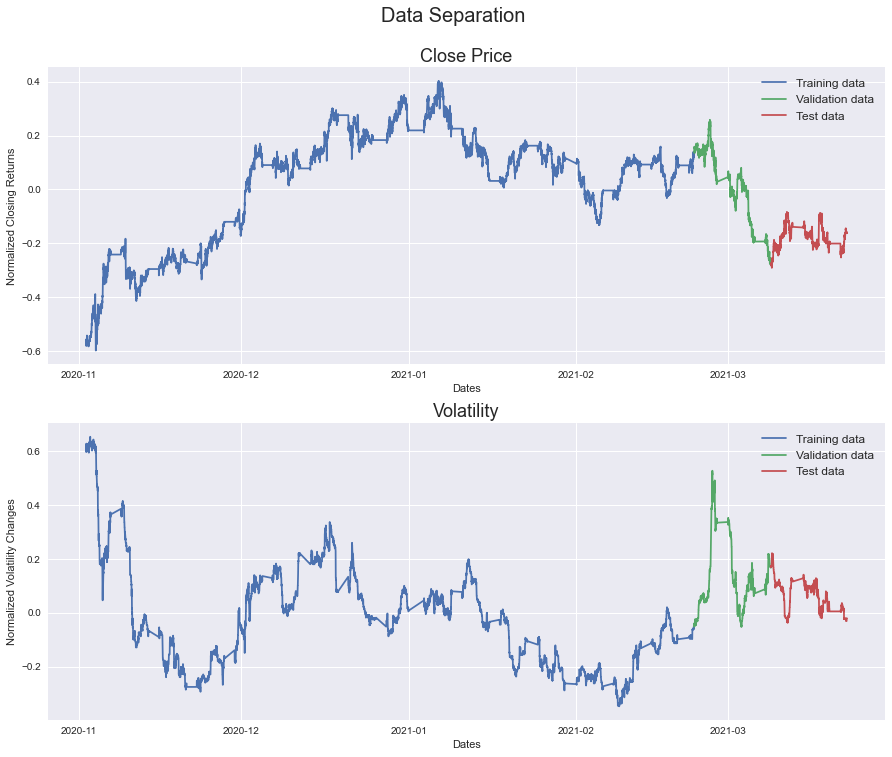

In [13]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(train_data_dates, df_train['EURUSD BGNE Curncy Bid Close'], label='Training data')  # !!!NEW
ax1.plot(val_data_dates, df_val['EURUSD BGNE Curncy Bid Close'], label='Validation data')  # !!!NEW
ax1.plot(test_data_dates, df_test['EURUSD BGNE Curncy Bid Close'], label='Test data')  # !!!NEW
ax1.set_xlabel('Dates')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(train_data_dates, df_train['EURUSDV1Y Curncy Trade Open'], label='Training data')  # !!!NEW
ax2.plot(val_data_dates, df_val['EURUSDV1Y Curncy Trade Open'], label='Validation data')  # !!!NEW
ax2.plot(test_data_dates, df_test['EURUSDV1Y Curncy Trade Open'], label='Test data')  # !!!NEW
ax2.set_xlabel('Dates')
ax2.set_ylabel('Normalized Volatility Changes')
ax2.set_title("Volatility", fontsize=18)
ax2.legend(loc="best", fontsize=12)

## Create chunks of training, validation and test data

In [14]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
  X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
  y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print('Training set shape', X_train.shape, y_train.shape)
print('Validation set shape', X_val.shape, y_val.shape)
print('Testing set shape' ,X_test.shape, y_test.shape)

Training set shape (11633, 128, 1273) (11633,)
Validation set shape (1342, 128, 1273) (1342,)
Testing set shape (1342, 128, 1273) (1342,)


## TimeVector

In [15]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

## Transformer

In [16]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

## Model

In [31]:
def create_model(input_shape):
  '''Initialize time and transformer layers'''
  time_embedding = Time2Vector(seq_len)
  attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
  attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

  '''Construct model'''
  in_seq = Input(shape=(seq_len, input_shape))
  x = time_embedding(in_seq)
  x = Concatenate(axis=-1)([in_seq, x])
#   x = Concatenate(axis=-1)([Dense(64)(in_seq), x])
  x = attn_layer1((x, x, x))
  x = attn_layer2((x, x, x))
  x = attn_layer3((x, x, x))
  x = GlobalAveragePooling1D(data_format='channels_first')(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.1)(x)
  out = Dense(1, activation='linear')(x)

  model = Model(inputs=in_seq, outputs=out)
  opt = keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss='mse', optimizer=opt, metrics=['mae', 'mape'])
  return model


model = create_model(df.shape[1])
model.summary()

callback = tf.keras.callbacks.ModelCheckpoint('../content/Transformer+TimeEmbedding{epoch}.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=8,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


if True: 
    history = model.fit(X_train, y_train,
                        batch_size=batch_size, 
                        epochs=3, 
                        callbacks=[callback],
                        validation_data=(X_val, y_val))  
    with open('../content/history.pkl', 'wb') as f:
        pickle.dump(history.history, f)
# else    
#    model.save(.h5)
#    model.load

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 1273)]  0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 1275)    0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 1275)    16337122    concatenate[0][0]            

In [17]:
model_last = sorted([i for i in os.listdir('../content') if 'hdf5' in i and 'Transformer+TimeEmbedding' in i])[-1]

In [18]:
model = tf.keras.models.load_model(
    os.path.join('../content', model_last),
    custom_objects={
        'Time2Vector': Time2Vector,
        'SingleAttention': SingleAttention,
        'MultiAttention': MultiAttention,
        'TransformerEncoder': TransformerEncoder
    }
)
with open('../content/history.pkl', 'rb') as f:
    history = pickle.load(f)

In [19]:
###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

KeyboardInterrupt: 

In [ ]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='EURUSD Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Dates')
ax11.set_ylabel('EURUSD Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='EURUSD Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Dates')
ax21.set_ylabel('EURUSD Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='EURUSD Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted EURUSD Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Dates')
ax31.set_ylabel('EURUSD Closing Returns')
ax31.legend(loc="best", fontsize=12)

## Model metrics

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history['loss'], label='Training loss (MSE)')
ax1.plot(history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history['mae'], label='Training MAE')
ax2.plot(history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history['mape'], label='Training MAPE')
ax3.plot(history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

## Model architecture overview

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="EURUSD_Transformer+TimeEmbedding.png",
    show_shapes=True,
    show_layer_names=True,
    expand_nested=True,
    dpi=96,)